✅ Session Ended


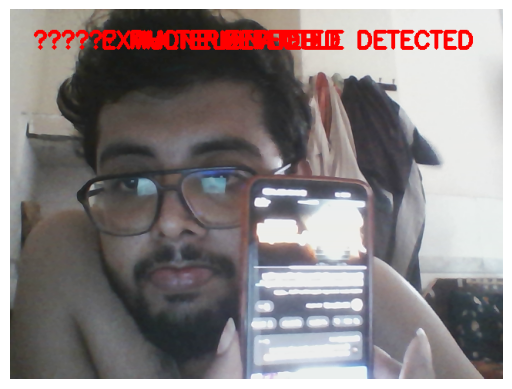

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, clear_outpute
from matplotlib import pyplot as plt
from ultralytics import YOLO
from datetime import datetime
import os
from collections import deque
import threading

# Load YOLO models
yolo_custom = YOLO(r"C:\Users\sagni\runs\detect\custom_phone_model4\weights\best.pt")
yolo_people = YOLO('yolov8n.pt')

print("📦 Custom model classes:", yolo_custom.names)

# Mediapipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=5)

# Eye and iris landmarks
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
LEFT_IRIS = 468
RIGHT_IRIS = 473

score_buffer = deque(maxlen=10)

# Folder for alerts
alert_folder = "alerts"
os.makedirs(alert_folder, exist_ok=True)

# Global flags
stop_flag = False
multiple_people_screenshots = []
phone_violation_screenshots = []

def save_violation(frame, reason="violation"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{alert_folder}/{reason}_{timestamp}.jpg"
    cv2.imwrite(filename, frame)
    print(f"📸 Saved screenshot: {filename}")
    return filename

def detect_custom_objects(frame):
    return yolo_custom.predict(frame, imgsz=640, conf=0.2, verbose=False)[0]

def detect_people_and_phones(frame):
    """Detect people and phones in the entire frame (foreground + background)"""
    result = yolo_people.predict(frame, imgsz=640, conf=0.3, verbose=False)[0]
    people_boxes = []
    phone_detected = False

    for box in result.boxes:
        cls_name = result.names[int(box.cls[0])].lower()
        if cls_name == "person":
            people_boxes.append(box)
        elif cls_name in ['cell phone', 'mobile phone', 'phone']:
            phone_detected = True
            print("📱 Phone detected in background (COCO)")
    
    return len(people_boxes), phone_detected

def detect_phone_reflection(frame, landmarks, w, h):
    """Check cropped iris regions for phone reflections"""
    for idx in [LEFT_IRIS, RIGHT_IRIS]:
        cx, cy = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
        r = 30
        eye_crop = frame[max(0, cy - r):cy + r, max(0, cx - r):cx + r]
        if eye_crop.size == 0:
            continue
        eye_res = yolo_custom.predict(eye_crop, imgsz=128, conf=0.2, verbose=False)[0]
        for box in eye_res.boxes:
            cls_name = yolo_custom.names[int(box.cls[0])].lower()
            if cls_name in ['phone', 'mobile phone', 'cell phone', 'smartphone']:
                print("👁️ Reflection phone detected:", cls_name)
                return True
    return False

def calculate_ear(landmarks, eye_indices, w, h):
    pts = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in eye_indices]
    v1 = np.linalg.norm(np.array(pts[1]) - np.array(pts[5]))
    v2 = np.linalg.norm(np.array(pts[2]) - np.array(pts[4]))
    hdist = np.linalg.norm(np.array(pts[0]) - np.array(pts[3]))
    return (v1 + v2) / (2.0 * hdist)

def is_blink(ear, threshold=0.21):
    return ear < threshold

def get_gaze(landmarks):
    lx, rx = landmarks[LEFT_IRIS].x, landmarks[RIGHT_IRIS].x
    ly, ry = landmarks[LEFT_IRIS].y, landmarks[RIGHT_IRIS].y
    avg_x, avg_y = (lx + rx) / 2, (ly + ry) / 2
    if 0.4 < avg_x < 0.6 and 0.4 < avg_y < 0.6:
        return 1.0
    elif 0.3 < avg_x < 0.7 and 0.3 < avg_y < 0.7:
        return 0.5
    return 0.0

def compute_concentration(gaze, blink):
    return round((0.7 * gaze + 0.3 * (0 if blink else 1)) * 100, 1)

def draw_alert(frame, text, color=(0, 0, 255)):
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

def draw_score_bar(frame, score):
    cv2.rectangle(frame, (20, 60), (220, 85), (50, 50, 50), -1)
    fill = int(score / 100 * 200)
    color = (0, 255, 0) if score >= 40 else (0, 128, 255)
    cv2.rectangle(frame, (20, 60), (20 + fill, 85), color, -1)
    cv2.putText(frame, f"Concentration: {score}%", (20, 55),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

def show_frame_in_notebook(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

def stop_camera_listener():
    global stop_flag
    input("🔘 Press Enter to stop camera...\n")
    stop_flag = True

def main():
    global stop_flag, multiple_people_screenshots, phone_violation_screenshots
    phone_violation_count = 0
    MAX_PHONE_WARNINGS = 3
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("❌ Webcam access failed")
        return

    threading.Thread(target=stop_camera_listener, daemon=True).start()

    try:
        while not stop_flag:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)
            h, w, _ = frame.shape
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)

            custom_results = detect_custom_objects(frame)
            custom_labels = [yolo_custom.names[int(box.cls[0])].lower() for box in custom_results.boxes]
            people_count, coco_phone_detected = detect_people_and_phones(frame)

            # Save screenshot if multiple people in background
            if people_count > 1:
                draw_alert(frame, "⚠️ MULTIPLE PEOPLE DETECTED")
                path = save_violation(frame, "multiple_people")
                multiple_people_screenshots.append(path)

            # Phone detected anywhere
            phone_detected = any(lbl in ['phone', 'mobile phone', 'cell phone'] for lbl in custom_labels) or coco_phone_detected
            reflection_detected = False
            if face_results.multi_face_landmarks:
                for landmarks_obj in face_results.multi_face_landmarks:
                    landmarks = landmarks_obj.landmark
                    if detect_phone_reflection(frame, landmarks, w, h):
                        reflection_detected = True
                        break

            if phone_detected or reflection_detected:
                reason = "phone_reflection" if reflection_detected else "phone_detected"
                draw_alert(frame, "⚠️ PHONE DETECTED")
                path = save_violation(frame, reason)
                phone_violation_screenshots.append(path)
                phone_violation_count += 1
                if phone_violation_count >= MAX_PHONE_WARNINGS:
                    draw_alert(frame, "🛑 EXAM TERMINATED")
                    save_violation(frame, "exam_terminated")
                    show_frame_in_notebook(frame)
                    break

            # Concentration scoring
            if face_results.multi_face_landmarks:
                for landmarks_obj in face_results.multi_face_landmarks:
                    landmarks = landmarks_obj.landmark
                    ear_l = calculate_ear(landmarks, LEFT_EYE, w, h)
                    ear_r = calculate_ear(landmarks, RIGHT_EYE, w, h)
                    avg_ear = (ear_l + ear_r) / 2
                    blink = is_blink(avg_ear)
                    gaze = get_gaze(landmarks)
                    score = compute_concentration(gaze, blink)
                    score_buffer.append(score)
                    smooth = int(np.mean(score_buffer))
                    draw_score_bar(frame, smooth)

            show_frame_in_notebook(frame)
            time.sleep(0.05)

    finally:
        cap.release()
        print("✅ Session Ended")

main()


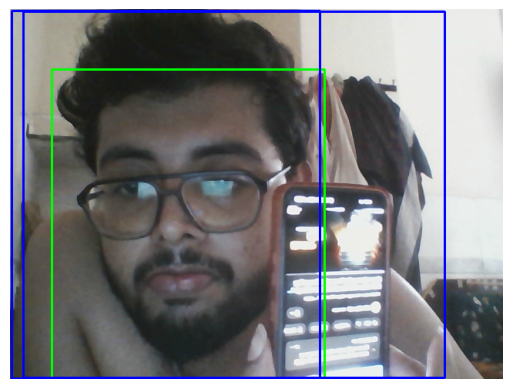

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from ultralytics import YOLO
from datetime import datetime
import os
from collections import deque
import threading

# Load YOLO models
yolo_custom = YOLO(r"C:\Users\sagni\runs\detect\custom_phone_model4\weights\best.pt")
yolo_people = YOLO('yolov8n.pt')

print("📦 Custom model classes:", yolo_custom.names)

# Mediapipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=1)

# Eye and iris landmarks
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
LEFT_IRIS = 468
RIGHT_IRIS = 473

score_buffer = deque(maxlen=10)

# Folder for alerts
alert_folder = "alerts"
os.makedirs(alert_folder, exist_ok=True)

# Global flags
stop_flag = False
background_people_saved = set()
phone_violation_count = 0
MAX_PHONE_VIOLATIONS = 3

def save_violation(frame, reason="violation"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{alert_folder}/{reason}_{timestamp}.jpg"
    cv2.imwrite(filename, frame)
    print(f"📸 Saved screenshot: {filename}")
    return filename

def detect_custom_objects(frame):
    """Detect phones with custom YOLO model"""
    return yolo_custom.predict(frame, imgsz=640, conf=0.2, verbose=False)[0]

def detect_people(frame):
    """Detect people with YOLOv8n"""
    result = yolo_people.predict(frame, imgsz=640, conf=0.3, verbose=False)[0]
    people_boxes = []
    for box in result.boxes:
        cls_name = result.names[int(box.cls[0])].lower()
        if cls_name == "person":
            people_boxes.append(box.xyxy[0].cpu().numpy())  # xyxy: [x1, y1, x2, y2]
    return people_boxes

def get_primary_user_box(landmarks, w, h):
    """Get bounding box around the primary user's face"""
    xs = [lm.x * w for lm in landmarks]
    ys = [lm.y * h for lm in landmarks]
    x1, y1, x2, y2 = int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))
    padding = 50
    x1, y1 = max(0, x1 - padding), max(0, y1 - padding)
    x2, y2 = min(w, x2 + padding), min(h, y2 + padding)
    return np.array([x1, y1, x2, y2])

def is_outside_primary(box, primary_box):
    """Check if a detected person is outside the primary user box"""
    px1, py1, px2, py2 = primary_box
    bx1, by1, bx2, by2 = box
    overlap_x = max(0, min(px2, bx2) - max(px1, bx1))
    overlap_y = max(0, min(py2, by2) - max(py1, by1))
    overlap_area = overlap_x * overlap_y
    box_area = (bx2 - bx1) * (by2 - by1)
    return overlap_area / box_area < 0.5

def detect_phone_reflection(frame, landmarks, w, h):
    """Detect phones in the iris regions (reflections)"""
    for idx in [LEFT_IRIS, RIGHT_IRIS]:
        cx, cy = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
        r = 30  # Crop radius
        eye_crop = frame[max(0, cy - r):cy + r, max(0, cx - r):cx + r]
        if eye_crop.shape[0] == 0 or eye_crop.shape[1] == 0:
            continue
        eye_res = yolo_custom.predict(eye_crop, imgsz=128, conf=0.2, verbose=False)[0]
        for box in eye_res.boxes:
            cls_name = yolo_custom.names[int(box.cls[0])].lower()
            if cls_name in ['phone', 'mobile phone', 'cell phone', 'smartphone']:
                print("👁️ Reflection phone detected:", cls_name)
                return True
    return False

def draw_alert(frame, text, color=(0, 0, 255)):
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

def show_frame_in_notebook(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

def stop_camera_listener():
    global stop_flag
    input("🔘 Press Enter to stop camera...\n")
    stop_flag = True

def main():
    global stop_flag, phone_violation_count, background_people_saved
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("❌ Webcam access failed")
        return

    threading.Thread(target=stop_camera_listener, daemon=True).start()

    try:
        while not stop_flag:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)
            h, w, _ = frame.shape
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)

            # Detect people
            people_boxes = detect_people(frame)

            # Detect custom objects (phones)
            custom_results = detect_custom_objects(frame)
            custom_labels = [yolo_custom.names[int(box.cls[0])].lower() for box in custom_results.boxes]
            phone_detected = any(lbl in ['phone', 'mobile phone', 'cell phone'] for lbl in custom_labels)

            if face_results.multi_face_landmarks:
                landmarks = face_results.multi_face_landmarks[0].landmark
                primary_box = get_primary_user_box(landmarks, w, h)
                cv2.rectangle(frame, tuple(primary_box[:2]), tuple(primary_box[2:]), (0, 255, 0), 2)

                # Check background people
                for box in people_boxes:
                    bx1, by1, bx2, by2 = map(int, box)
                    cv2.rectangle(frame, (bx1, by1), (bx2, by2), (255, 0, 0), 2)
                    if is_outside_primary(box, primary_box):
                        hash_id = f"{bx1}_{by1}_{bx2}_{by2}"
                        if hash_id not in background_people_saved:
                            background_people_saved.add(hash_id)
                            draw_alert(frame, "⚠️ BACKGROUND PERSON DETECTED")
                            save_violation(frame, "background_person")

                # Check eye reflections for phones
                if detect_phone_reflection(frame, landmarks, w, h):
                    phone_detected = True

            if phone_detected:
                phone_violation_count += 1
                draw_alert(frame, f"⚠️ PHONE DETECTED ({phone_violation_count})")
                save_violation(frame, "phone_detected")
                if phone_violation_count >= MAX_PHONE_VIOLATIONS:
                    draw_alert(frame, "🛑 EXAM TERMINATED")
                    save_violation(frame, "exam_terminated")
                    show_frame_in_notebook(frame)
                    break

            show_frame_in_notebook(frame)
            time.sleep(0.05)

    finally:
        cap.release()
        print("✅ Session Ended")

main()
